# Section 6 

**Yueying Sun and Johannes Ruf**

January 2024

In this notebook, we simulate the stock value path given that the bond value path follows a binomial model. 

First, we import all modules that we need and seed the random number generator. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
rng = np.random.default_rng(seed=123456)

## Bond price

We assume the bond $(B_t)_{t \in [0,T]}$ follows a $n$-step binomial model. Let $dt = T/n$. Fix a set of points $0 < t_1 < \ldots < t_n \leq T $, where $t_i = dt * i$. Fix $B_0$ as a constant and for $i = \{1,2,3,...,n\}$, define
$$B_{i} = B_{i-1} e^{Y_i},$$
where $(Y_1, \ldots, Y_n)$ are i.i.d random variables that takes value either $\sigma * dt$ with probability $p$ or $- \sigma * dt$ with probability $1-p$.

In [3]:
def simulate_bond(rng, σ, T, n, B0, p):
    
    dt = T / n
    u = np.exp(σ * dt)
    d = np.exp(- σ * dt)
    
    #generate Bernoulli
    ud_simulation = rng.choice([u,d], n, p = [p,1-p])
    
    #simulate one path
    B_tmp = B0 * ud_simulation.cumprod()
    B = np.insert(B_tmp, 0, B0)
    return B

## Stock price

Now we compute the mandate-implied stock value based on three different mandates. We derive the mandate-implied value $(P_t)_{t \in [0,T]}$ for a specific bond value path $(B_t)_{t \in [0,T]}$.

In each case, we assume $\mathfrak{m}^{(j)}_0 \ (j = 1, 2, 3)$ is constant with value $0.65$ and correspondingly, the mandate-implied value $P^j_0$ satisfies
$$P^j_0 = \frac{\mathfrak{m}^{(j)}_0(1)}{1 - \mathfrak{m}^{(j)}_0(1)} B_0 \ (j = 1, 2, 3).$$

### Case 1

First we consider a constant mandate. Let $\mathfrak{m}^{(1)}_{t_i} = 0.65$ for each $i \in \{1,2, \ldots, n\}$ and the mandate-implied value function satisfies
$$P^{(1)}_i = \frac{\mathfrak{m}^{(1)}_i(1)}{1 - \mathfrak{m}^{(1)}_i(1)} B_i.$$


In [4]:
def compute_stock_m1(B, T, n, P0, m=0.65):
    dt = T / n
    
    P = np.zeros(n+1)
    P[0] = P0
    
    for i in range(n):
        P[i+1] = m / (1 - m) * B[i+1]
        
    return P

### Case 2

We now consider a mandate that yields higher volatility in stock than bond. We assume that the mandate-implied value is iteratively given as
$$P^{(2)}_i = \left(\frac{B_{i}}{B_{i-1}} \right)^2 P^{(2)}_{i-1}, \quad i \in \{1,2, \ldots, n\}.$$

In [5]:
def compute_stock_m2(B, T, n, P0):
    dt = T / n
    
    P = np.zeros(n+1)
    P[0] = P0
    
    for i in range(n):
        P[i+1] = P[i] * (B[i+1] / B[i])**2
        
    return P

### Case 3

We at last consider a mandate that yields lower volatility in stock than bond.  We assume that the mandate-implied value is iteratively given as
$$P^{(3)}_i = \sqrt{\frac{B_{i}}{B_{i-1}}} P^{(3)}_{i-1}, \quad i \in \{1,2, \ldots, n\}.$$

In [6]:
def compute_stock_m3(B, T, n, P0):
    dt = T / n
    
    P = np.zeros(n+1)
    P[0] = P0
    
    for i in range(n):
        P[i+1] = P[i] * (B[i+1] / B[i]) ** 0.5
         
    return P

## Simulation
We first give the following parameters.

In [7]:
T = 1
n = 250 #how many periods of time

σ = 0.2
p = 0.5

B0 = 1
m0 = 0.65 #initial manadate
P0 = B0 * m0 / (1 - m0)

The below cell runs one simulation for each of the three mandate-implied stock values above.

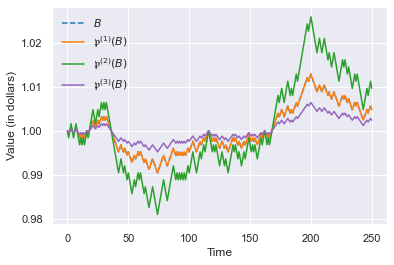

In [8]:
bond_path = simulate_bond(rng, σ, T, n, B0, p)
bond_path_norm = bond_path/B0

stock_path1 = compute_stock_m1(bond_path, T, n, P0)
stock_path_norm1 = stock_path1/P0

stock_path2 = compute_stock_m2(bond_path, T, n, P0)
stock_path_norm2 = stock_path2/P0

stock_path3 = compute_stock_m3(bond_path, T, n, P0)
stock_path_norm3 = stock_path3/P0

_, ax = plt.subplots()
ax.plot(bond_path_norm, linestyle = 'dashed', color = '#1f77b4');
ax.plot(stock_path_norm1,  color = '#ff7f0e');#con
ax.plot(stock_path_norm2,  color = '#2ca02c');#more
ax.plot(stock_path_norm3,  color = '#9467bd');#less
ax.set_ylabel('Value (in dollars)')
ax.set_xlabel('Time')
plt.legend(['$B$','$\mathfrak{p}^{(1)}(B)$','$\mathfrak{p}^{(2)}(B)$','$\mathfrak{p}^{(3)}(B)$'], frameon=False);
#plt.savefig('bm3_simuin1.png',bbox_inches='tight');

The below cell computes each return of the bond and the three mandate-implied stock values above. 

In [9]:
bondreturn = np.diff(bond_path_norm) / bond_path_norm[:-1]
stockreturn1 = np.diff(stock_path_norm1) / stock_path_norm1[:-1]
stockreturn2 = np.diff(stock_path_norm2) / stock_path_norm2[:-1]
stockreturn3 = np.diff(stock_path_norm3) / stock_path_norm3[:-1]

Next we compute the annualised standard deviation of the above returns.

In [10]:
stockreturn1.std(ddof = 1) * np.sqrt(250)

0.01267083558457429

In [11]:
stockreturn2.std(ddof = 1) * np.sqrt(250)

0.025341679278484144

In [12]:
stockreturn3.std(ddof = 1) * np.sqrt(250)

0.006335417285452722